## Building custom estimators in sklearn



It is possible to create your own estimators in sklearn. Doing this requires knowing some advanced Python programming skills. We have to create a *class* that inherits from the `sklearn.base.BaseEstimator` class to get Estimator capabilities, and `sklearn.base.RegressorMixin` to get Model capabilities like scoring. Then, we have to define `fit` and `predict` class methods. The `fit` method has a required signature which takes the data, and returns the estimator. This is the function where we fit the parameters and store the result in the class. The function we want to fit is nonlinear in the parameters:

$k(T; k_0, E_A) = k_0 e^{-E_A / (RT)}$.

So, we need to provide an initial guess to help find the fit. We derive an analytical guess for this from the data, and then use a nonlinear least squares routine to do the fitting.

Second, we need a predict function, which simply evaluates our model for new temperatures.

This class does not have any hyperparameters associated with it, so we do not need an <u><u>init</u></u> function here.

We define some "private" functions, which *start* with an \_, indicating these are not intended for users to use, they are only used internally. These functions hold the model and objective function.

Here is the definition of the class.



In [1]:
from scipy.optimize import leastsq
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin


class ArrheniusRegressor(BaseEstimator, RegressorMixin):
    R = 8.314 # J / mol / K

    def _arrhenius(self, params, X):
        k0, Ea = params
        return k0 * np.exp(-Ea / self.R / X)

    def _objective(self, params, y, x):
        err = y - self._arrhenius(params, x)
        return err

    def fit(self, X, y):
        '''
        X is the temperature (in K)
        y is the rate constants (in mol/s)

        Fits the Arrhenius equation to X, y.
        '''

        # We need a reasonable guess for the fitting. We estimate it from a 2-pt
        # formula derived from the Arrhenius equation:

        # k1 = k0 exp(-Ea/(R T1))
        # k2 = k0 exp(-Ea/(R T2))
        # Ea = (R T1 T2)/(T1 - T2) * ln(k1 / k2)
        # k0 = exp(ln k1 + Ea / (R T1))
        # We choose Tmin and Tmax for this.
        iT1 = np.argmin(X)
        iT2 = np.argmax(X)

        T1 = X[iT1]
        T2 = X[iT2]
        k1 = y[iT1]
        k2 = y[iT2]

        # These are the initial guesses
        Ea = self.R * T1 * T2 / (T1 - T2) * np.log(k1 / k2)
        k0 = np.exp(np.log(k1) + Ea / self.R / T1)

        self.coefs_, ier = leastsq(self._objective,
                                   (k0, Ea), args=(y, X))
        if ier not in [1, 2, 3, 4]:
            raise Exception('Fitting failed.')

        return self

    def predict(self, X):
        """Returns predictions for X."""
        return self._arrhenius(self.coefs_, X)

Overall, it is not too complex, but requires you to know how to build a class that inherits from two other classes. That is an advanced topic.

Once it is done though, we can use it as easily as all the other models.



In [1]:
data = np.array([[375,	1.68e-5],
                 [400,	3.5e-5],
                 [500,	4.2e-4],
                 [600,	2.11e-3]])

X = data[:, 0]
y = data[:, 1]


m = ArrheniusRegressor()
m.fit(X, y)
m.coefs_

array([6.79049544e+00, 4.02891385e+04])

Even though we did not define a `score` class method, our regressor *inherits* this method from one of the classes it is based on.



In [1]:
m.score(X, y)

0.9999982852927228

Finally, we can *predict* things with our new model.



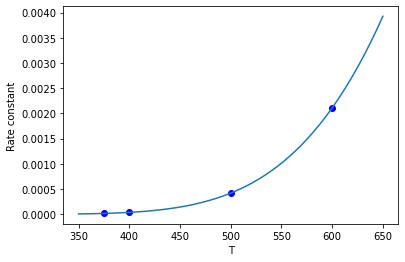

In [1]:
import matplotlib.pyplot as plt
plt.plot(X, y, 'bo')

xfit = np.linspace(350, 650)
plt.plot(xfit, m.predict(xfit))
plt.xlabel('T')
plt.ylabel('Rate constant');

That is it. This is more work than a simple nonlinear regression with numpy arrays, but in theory this is compatible with the sklearn pipeline idea, and you get some functionality "for free" because of the inheritance.

You do have to be clever in the fit function here; because it is a nonlinear regression, we have to initialize with a guess. You may get different fits for different guesses in some cases, which is not an easy thing to deal with. One solution is to use a random number generator with a seed to control reproducibility.

